# Finding Pittsburgh's Safest Neighborhood

## Introduction

Our team analyzed **four key datasets** to determine the safest neighborhoods in Pittsburgh:

1. 🚔 **Non-Traffic Citations**  
   - Low-level offenses like disorderly conduct and public drunkenness  
   - Measures general public safety and order  

2. 🚒 **Fire Incidents**  
   - Frequency and severity of fires  
   - Indicator of infrastructure safety and emergency response  

3. 👮 **Police Arrest Data**  
   - Serious criminal activity patterns  
   - Shows violent crime distribution  

4. 🌊 **Flood Zones**  
   - Natural disaster risk assessment  
   - Environmental safety consideration  

## Our Safety Metric

We defined **"Safest"** through a weighted combination of:
- Fewest citations per capita  
- Lowest arrest rates  
- Minimal fire incidents  
- Lowest flood risk  


## First DataSet: Non-Traffic Citations
Mariia Sierova

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

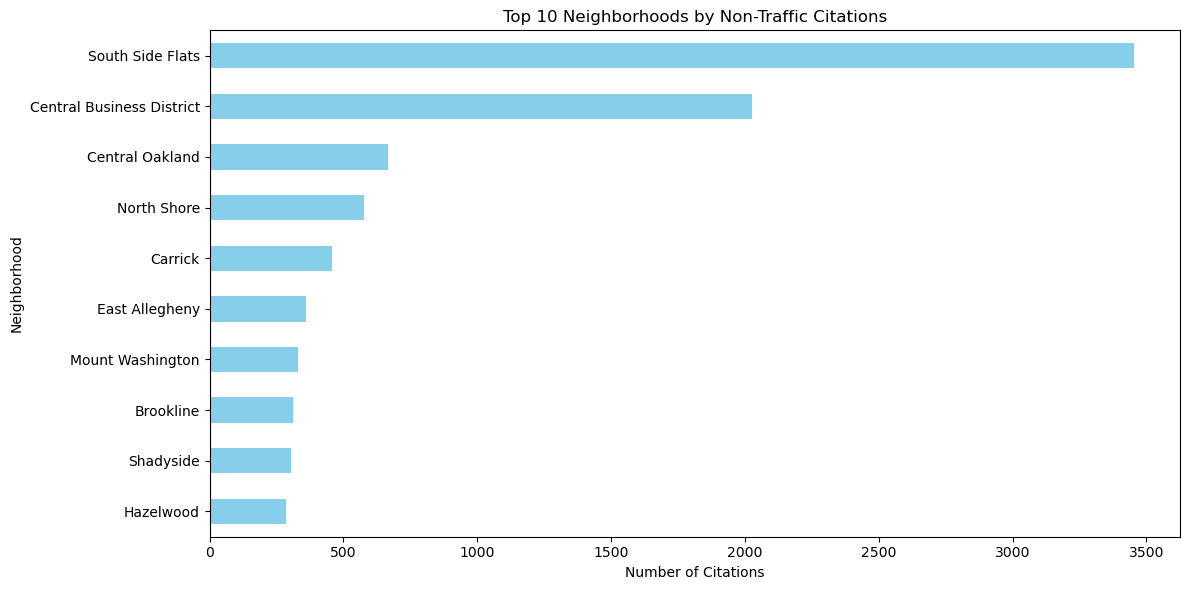

In [3]:
citations = pd.read_csv('citations.csv')
# Keep key columns
cols_to_keep = ['GENDER', 'RACE', 'AGE', 'CITEDTIME', 'OFFENSES', 'NEIGHBORHOOD', 'X', 'Y']
citations = citations[cols_to_keep]
# Drop rows with missing neighborhood 
citations = citations.dropna(subset=['NEIGHBORHOOD'])
# Convert CITEDTIME to datetime
citations['CITEDTIME'] = pd.to_datetime(citations['CITEDTIME'], errors='coerce')
# Extract year for time-based analysis
citations['YEAR'] = citations['CITEDTIME'].dt.year

# Count citations per neighborhood
neighborhood_counts = citations['NEIGHBORHOOD'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
neighborhood_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Neighborhoods by Non-Traffic Citations')
plt.xlabel('Number of Citations')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

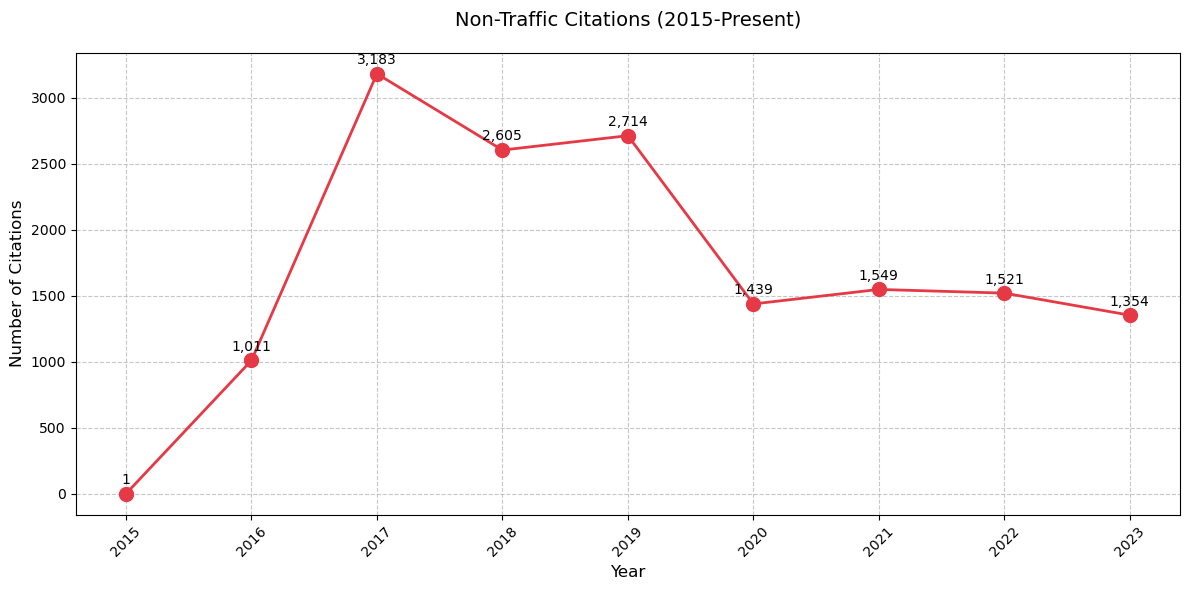

In [4]:
# Filter data for 2015 and later
citations_2015plus = citations[citations['YEAR'] >= 2015]

# Group by year and count citations
annual_counts = citations_2015plus.groupby('YEAR').size()

# Plot with enhanced styling
plt.figure(figsize=(12, 6))
ax = annual_counts.plot(marker='o', 
                       linestyle='-', 
                       color='#e63946', 
                       linewidth=2, 
                       markersize=10)

# Customize the plot
plt.title('Non-Traffic Citations (2015-Present)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Citations', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of each point
for x, y in zip(annual_counts.index, annual_counts.values):
    ax.text(x, y+50, f'{y:,}', ha='center', va='bottom', fontsize=10)

# Adjust x-axis ticks to show every year
plt.xticks(annual_counts.index, rotation=45)

plt.tight_layout()
plt.show()

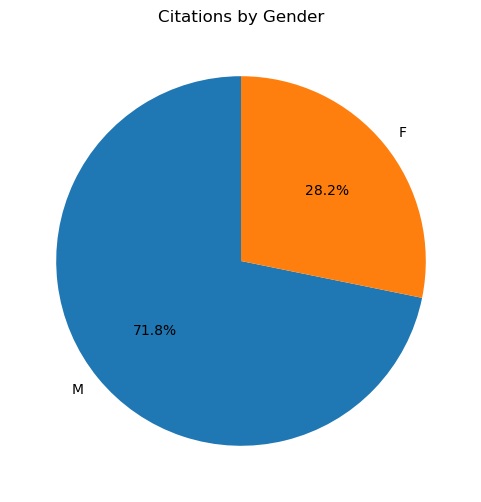

In [5]:
gender_counts = citations['GENDER'].value_counts()

plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Citations by Gender')
plt.ylabel('')
plt.show()

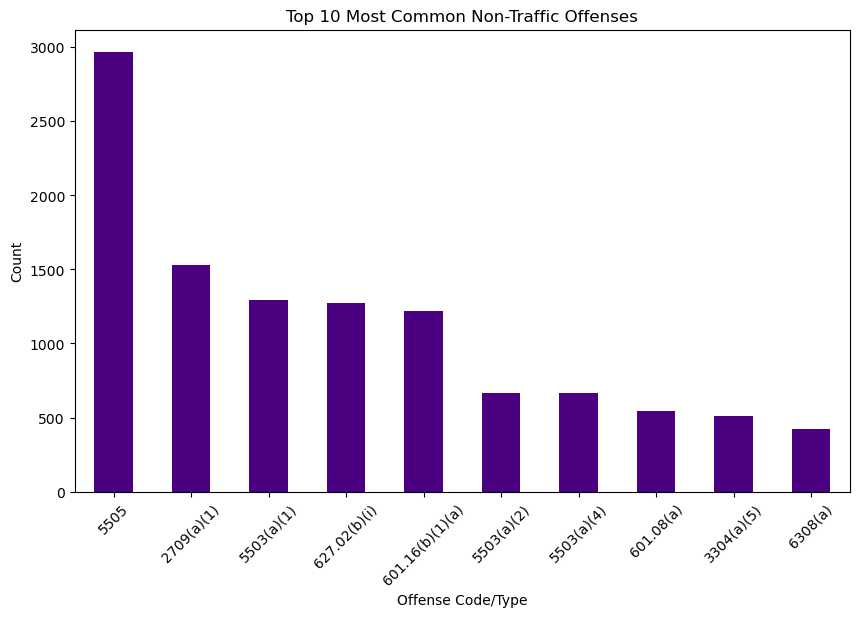

,Statute Code,Legal Definition
0,5505,Public Drunkenness
1,5503(a)(1),Disorderly Conduct - Hazardous Physical Offense
2,5503(a)(2),Disorderly Conduct - Unreasonable Noise
3,5503(a)(4),Disorderly Conduct - Obscene Language/Gestures
4,2709(a)(1),Harassment - Communication
5,3304(a)(5),Criminal Mischief - Damage Property
6,6308(a),Underage Drinking
7,627.02(b)(i),Public Urination/Defecation
8,601.16(b)(1)(a),Littering in Public Space
9,601.08(a),Open Container Violation


In [6]:
# Extract primary offense (first part of OFFENSES string)
citations['PRIMARY_OFFENSE'] = citations['OFFENSES'].str.split().str[0]

# Top 10 offenses
top_offenses = citations['PRIMARY_OFFENSE'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_offenses.plot(kind='bar', color='indigo')
plt.title('Top 10 Most Common Non-Traffic Offenses')
plt.xlabel('Offense Code/Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



# Decoder dictionary
offense_decoder = {
    '5505': 'Public Drunkenness',
    '5503(a)(1)': 'Disorderly Conduct - Hazardous Physical Offense',
    '5503(a)(2)': 'Disorderly Conduct - Unreasonable Noise',
    '5503(a)(4)': 'Disorderly Conduct - Obscene Language/Gestures',
    '2709(a)(1)': 'Harassment - Communication',
    '3304(a)(5)': 'Criminal Mischief - Damage Property',
    '6308(a)': 'Underage Drinking',
    '627.02(b)(i)': 'Public Urination/Defecation',
    '601.16(b)(1)(a)': 'Littering in Public Space',
    '601.08(a)': 'Open Container Violation'
}

# Create and display the clean mapping table
mapping_table = pd.DataFrame({
    'Statute Code': list(offense_decoder.keys()),
    'Legal Definition': list(offense_decoder.values())
})

# Style with clean formatting
styled_table = mapping_table.style \
    .set_properties(**{
        'text-align': 'left',
        'font-family': 'Arial'
    }) \
    .set_caption('Pennsylvania/Pittsburgh Offense Code Reference') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#2a9d8f'), 
                 ('color', 'white'),
                 ('font-weight', 'bold')]
    }])

styled_table

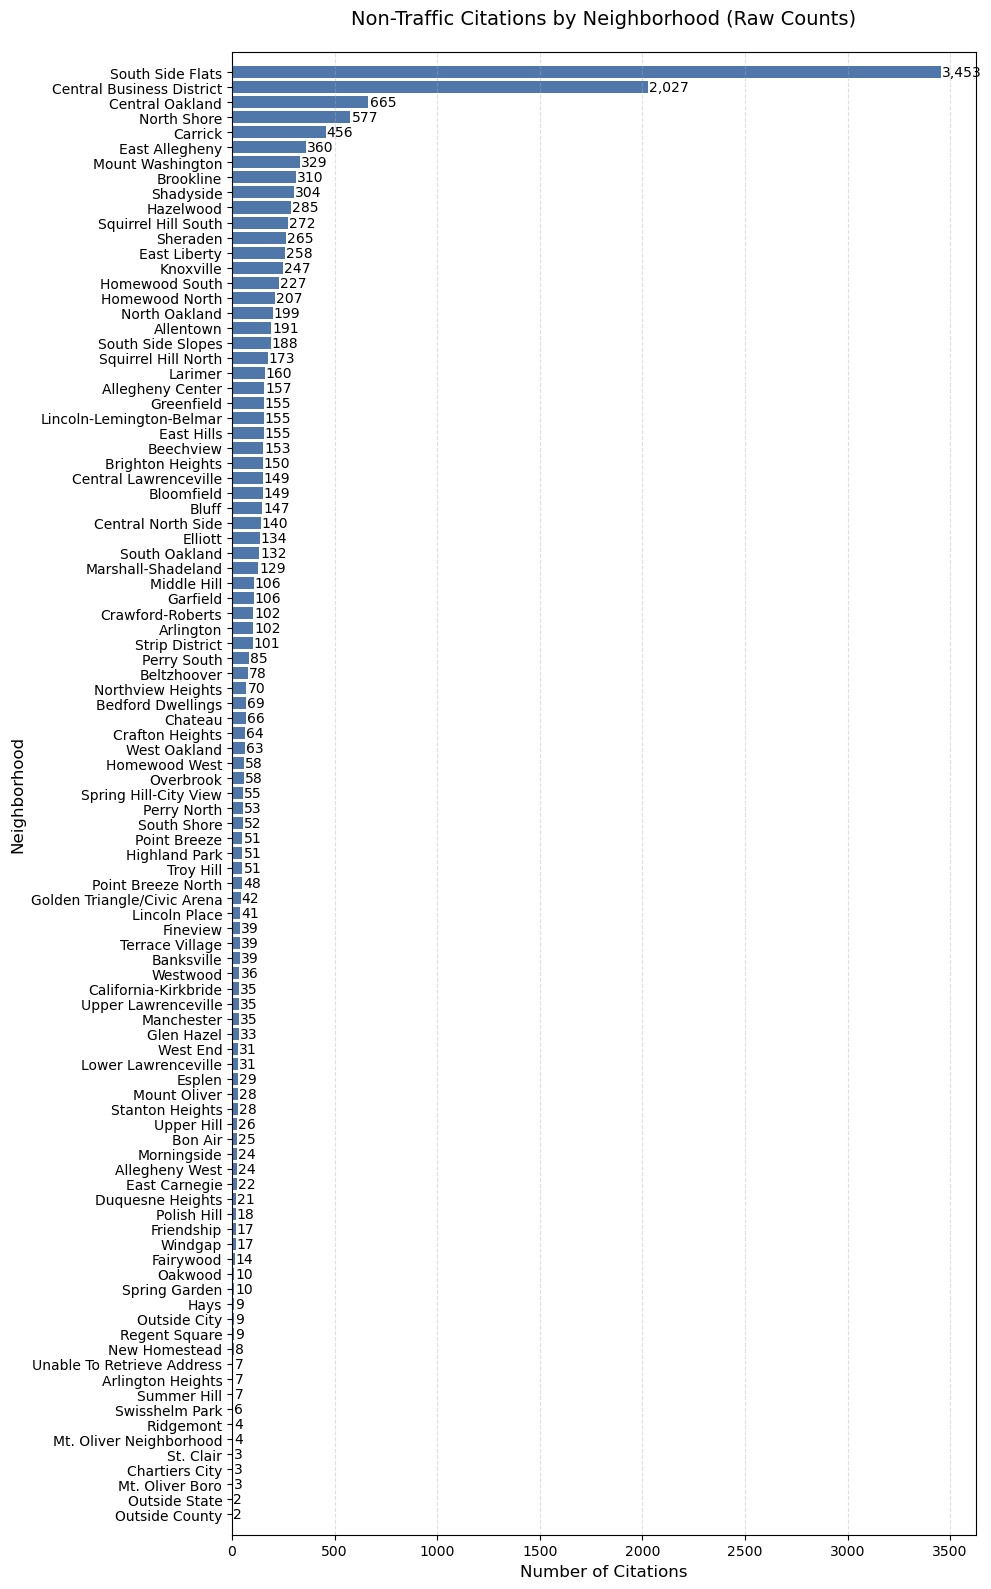

In [7]:
# Get neighborhood counts (sorted ascending)
neighborhood_counts = citations['NEIGHBORHOOD'].value_counts().sort_values()

# Create plot
plt.figure(figsize=(10, 16))
bars = plt.barh(neighborhood_counts.index, neighborhood_counts.values, 
               color='#4f77aa', height=0.8)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', 
             va='center', ha='left', fontsize=10)

# Formatting
plt.title('Non-Traffic Citations by Neighborhood (Raw Counts)', fontsize=14, pad=20)
plt.xlabel('Number of Citations', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()

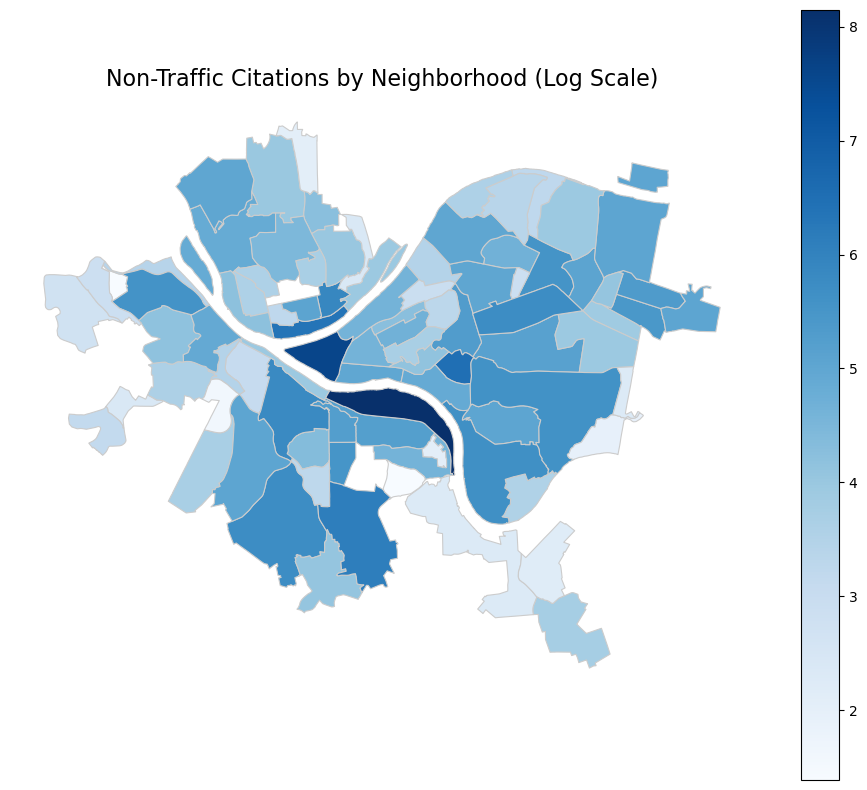

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load citation data
citations = pd.read_csv('citations.csv')

# Keep relevant columns
cols_to_keep = ['NEIGHBORHOOD', 'X', 'Y']
citations = citations[cols_to_keep]

# Drop rows without a neighborhood
citations = citations.dropna(subset=['NEIGHBORHOOD'])

# Count citations per neighborhood
citation_counts = citations['NEIGHBORHOOD'].value_counts().reset_index()
citation_counts.columns = ['NEIGHBORHOOD', 'Citation_Count']

# Load the shapefile for Pittsburgh neighborhoods
gdf = gpd.read_file("Neighborhoods_.shp")

# Merge citation counts with geodata
merged = gdf.merge(citation_counts, how='left', left_on='hood', right_on='NEIGHBORHOOD')

# Add a small constant to avoid log(0)
merged['Citation_Count_Log'] = np.log1p(merged['Citation_Count'])

fig, ax = plt.subplots(figsize=(12, 10))
merged.plot(column='Citation_Count_Log', 
            cmap='Blues', 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8', 
            legend=True)

ax.set_title('Non-Traffic Citations by Neighborhood (Log Scale)', fontsize=16)
ax.axis('off')
plt.show()



# Second Data Set: Arrests 

### By identifying which neighborhoods have the fewest arrests, the data also highlights which areas are likely the safest in the city. The neighborhoods with the highest number of arrests were consistent with areas typically associated with higher crime rates, and may not be safe. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the dataset
arrests = pd.read_csv('pgharrests.csv', on_bad_lines='skip')

# Load Shapefile for Pittsburgh Neighborhoods
gdf = gpd.read_file("City_of_Pittsburgh_Neighborhoods.shp")

# Keep key columns
cols_to_keep = ['AGE', 'GENDER', 'RACE', 'ARRESTTIME', 'ARRESTLOCATION', 'OFFENSES', 'INCIDENTNEIGHBORHOOD', 'X', 'Y']
arrests = arrests[cols_to_keep]

# Drop rows with missing neighborhood 
arrests = arrests.dropna(subset=['INCIDENTNEIGHBORHOOD'])

# Convert ARRESTTIME to datetime
arrests['ARRESTTIME'] = pd.to_datetime(arrests['ARRESTTIME'], errors='coerce')

# Extract year for time-based analysis
arrests['YEAR'] = arrests['ARRESTTIME'].dt.year

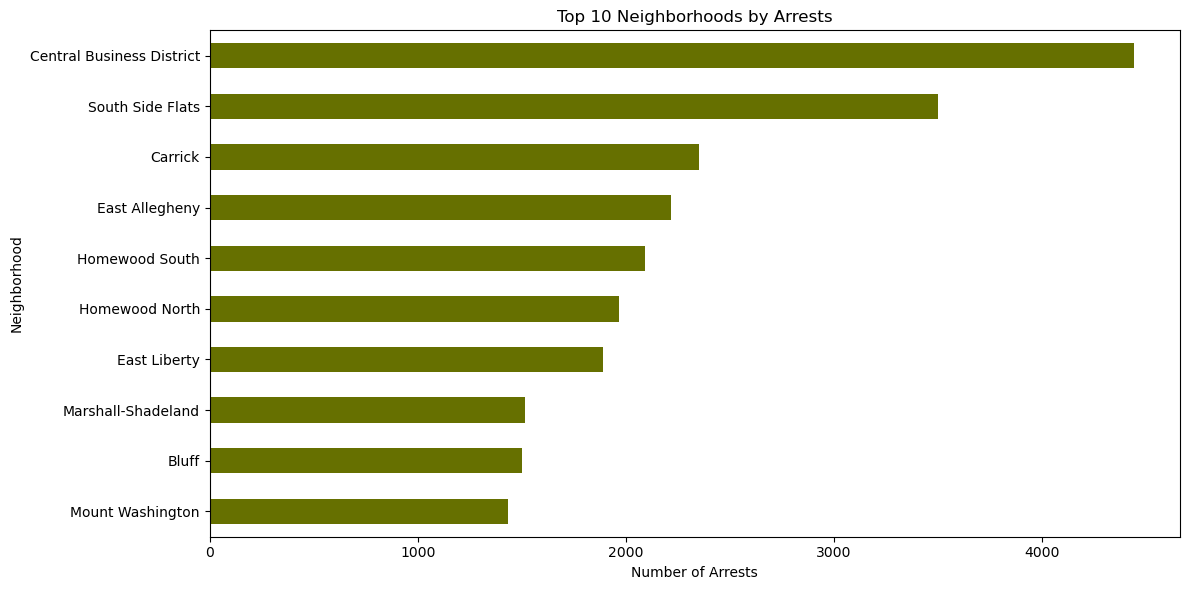

In [3]:
# Count citations per neighborhood
neighborhood_counts = arrests['INCIDENTNEIGHBORHOOD'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
neighborhood_counts.sort_values().plot(kind='barh', color='#667000')
plt.title('Top 10 Neighborhoods by Arrests')
plt.xlabel('Number of Arrests')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

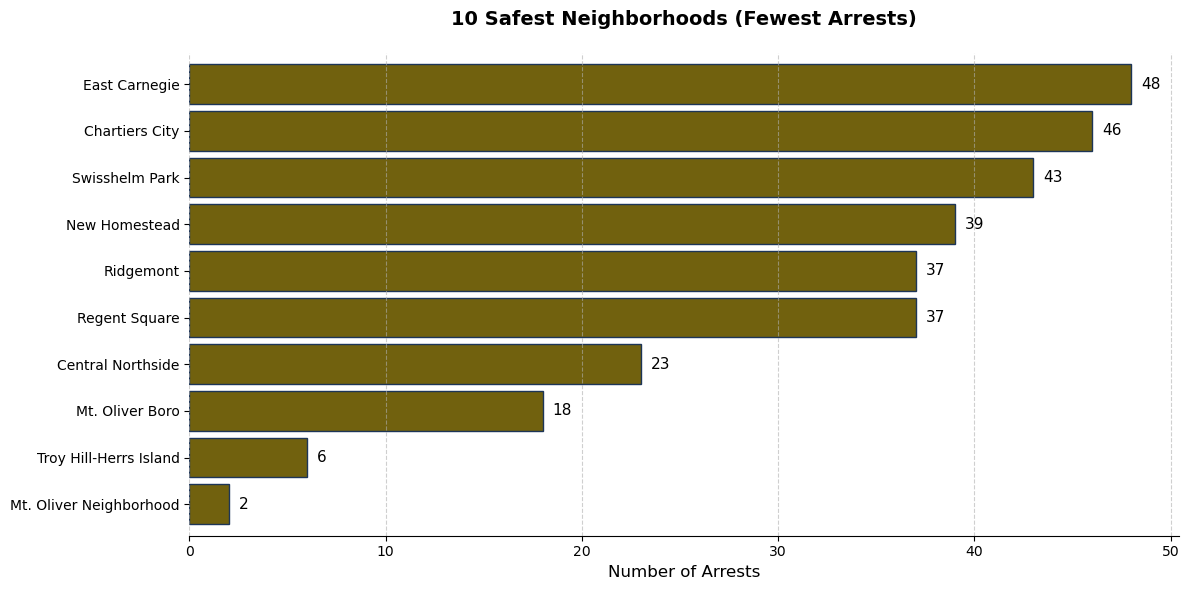

In [4]:
# Count citations per neighborhood and get BOTTOM 10
neighborhood_counts = arrests['INCIDENTNEIGHBORHOOD'].value_counts().nsmallest(10)

# Create the plot
plt.figure(figsize=(12, 6))
ax = neighborhood_counts.sort_values(ascending=True).plot(
    kind='barh',
    color='#71610e',  
    edgecolor='#1d3557',
    width=0.85
)

# Customize appearance
plt.title('10 Safest Neighborhoods (Fewest Arrests)', 
         fontsize=14, pad=20, weight='bold')
plt.xlabel('Number of Arrests', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add value labels
for i, v in enumerate(neighborhood_counts.sort_values()):
    ax.text(v + 0.5, i, f"{int(v)}", 
            color='black', 
            va='center',
            fontsize=11)

# Remove top/right spines
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

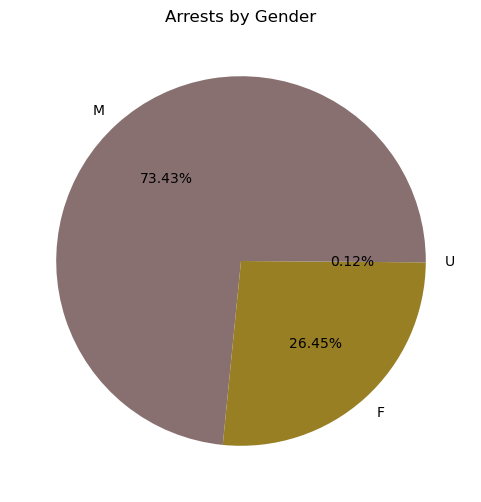

In [5]:
gender_counts = arrests['GENDER'].value_counts()

plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%.2f%%', colors=['#897070', '#987f24'])
plt.title('Arrests by Gender')
plt.ylabel('')
plt.show()

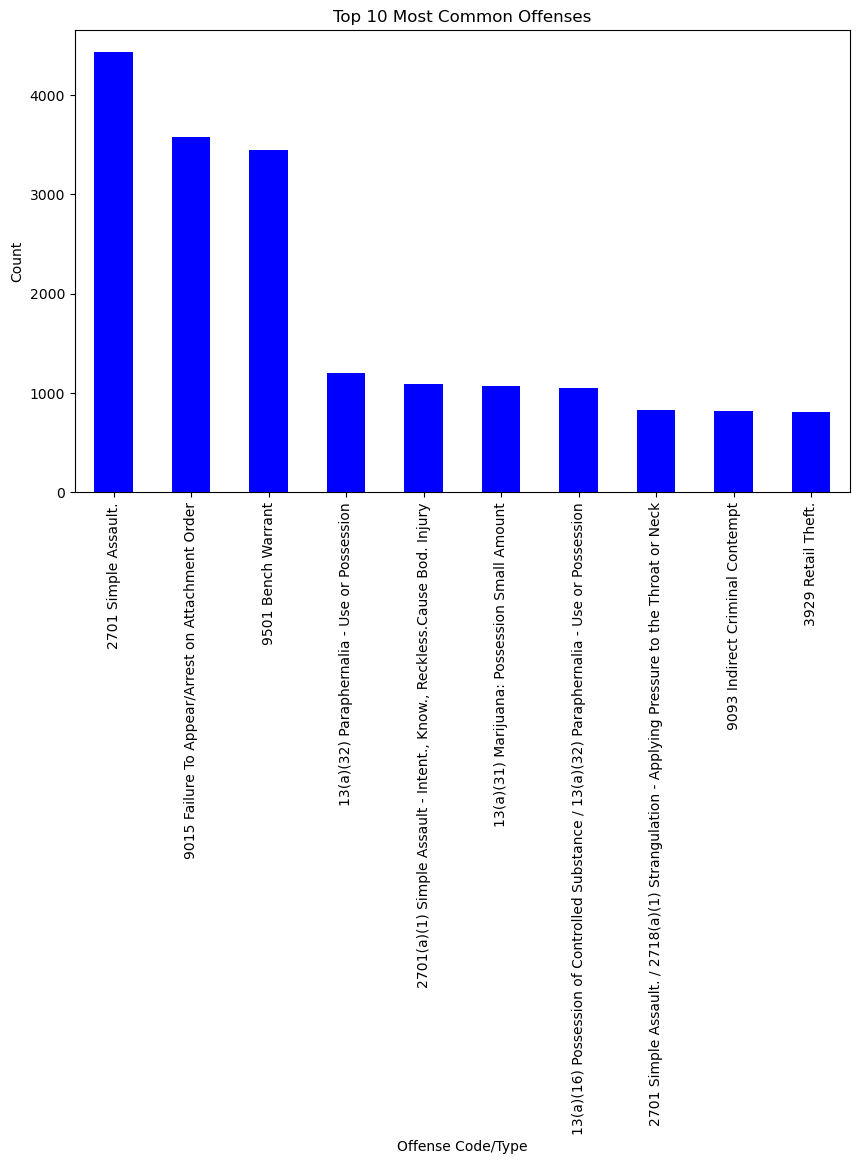

In [6]:

# Top 10 offenses
top_offenses = arrests['OFFENSES'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_offenses.plot(kind='bar', color='blue')
plt.title('Top 10 Most Common Offenses')
plt.xlabel('Offense Code/Type')
plt.ylabel('Count')
plt.xticks
plt.show()

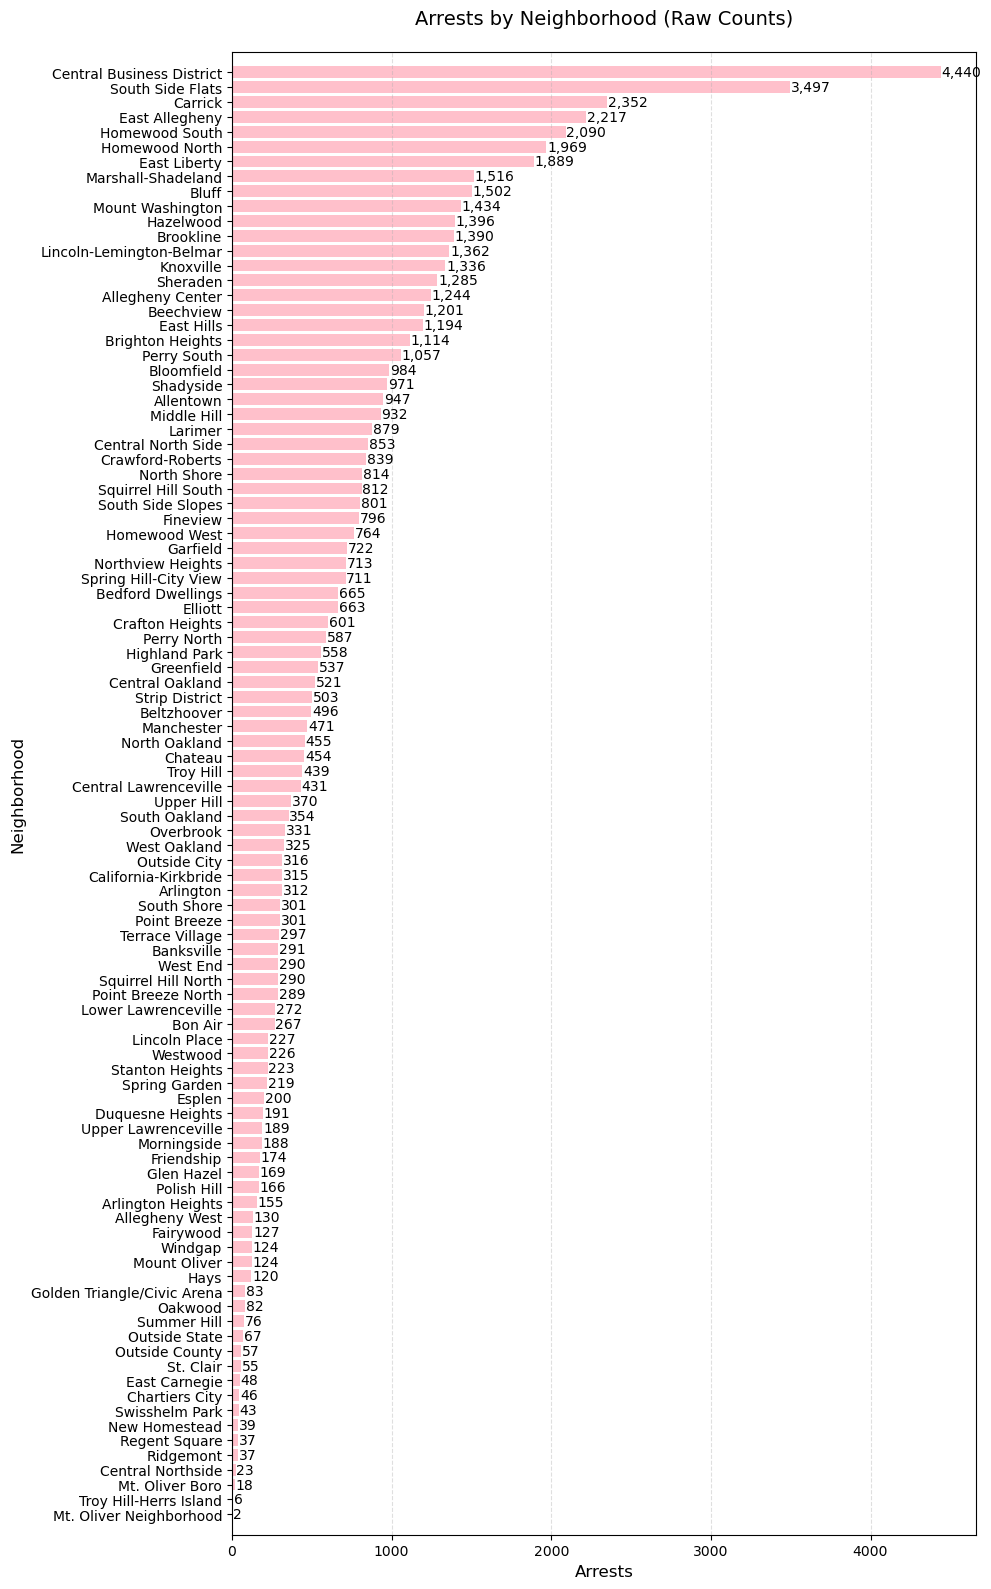

In [7]:
# Get neighborhood counts (sorted ascending)
neighborhood_counts = arrests['INCIDENTNEIGHBORHOOD'].value_counts().sort_values()

# Create plot
plt.figure(figsize=(10, 16))
bars = plt.barh(neighborhood_counts.index, neighborhood_counts.values, 
               color='pink', height=0.8)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', 
             va='center', ha='left', fontsize=10)

# Formatting
plt.title('Arrests by Neighborhood (Raw Counts)', fontsize=14, pad=20)
plt.xlabel('Arrests', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()

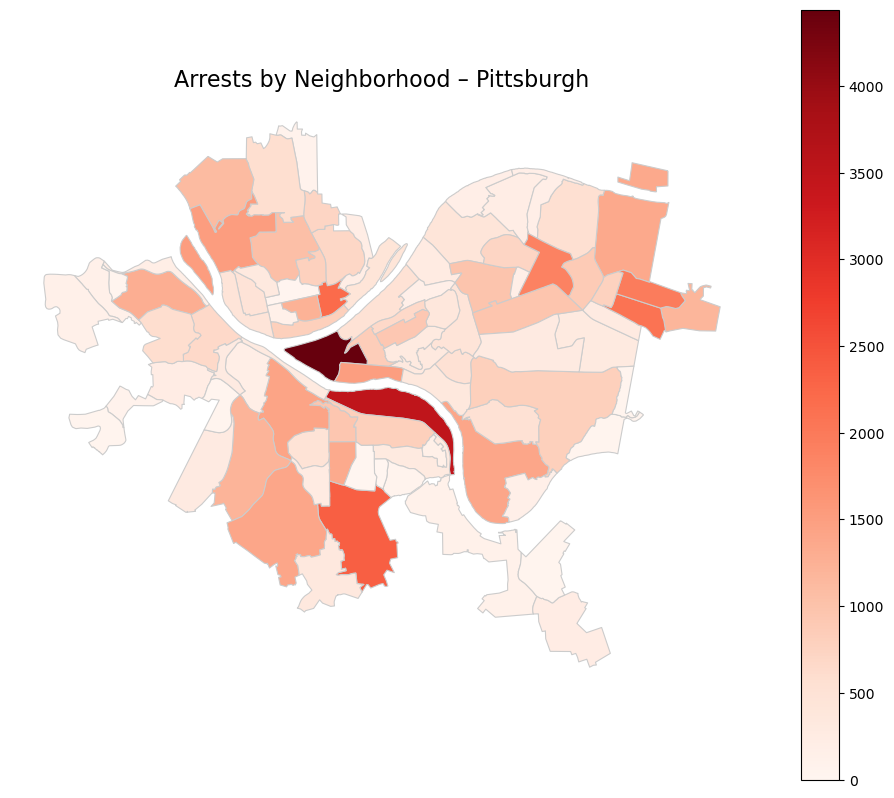

In [ ]:
arrest_counts = arrests.groupby('INCIDENTNEIGHBORHOOD').size().reset_index(name='Arrest_Count')

 
 
merged = gdf.merge(arrest_counts, how="left", left_on="HOOD", right_on="INCIDENTNEIGHBORHOOD")

# 5. Fill missing data with 0 (neighborhoods with no arrests)
merged['Arrest_Count'] = merged['Arrest_Count'].fillna(0)

# 6. Plot
fig, ax = plt.subplots(figsize=(12, 10))
merged.plot(column='Arrest_Count', 
            cmap='Reds', 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8', 
            legend=True)

ax.set_title('Arrests by Neighborhood – Pittsburgh', fontsize=16)
ax.axis('off')
plt.show()

# Conclusions

#### The results of the analysis aligned closely with what I personally already assumed about crime patterns in the city, with one exception. I was surprised with the number of arrests in Mt Washington. There weren’t any unexpected trends in the demographics or timing of arrests. The data provided a clear view of where and when arrests are most common. Overall, the findings confirmed existing perceptions about neighbohoods with good reputations, only revealing one major surprise, in my opinion.

# Third Data Set - Fire Incidents

### Looking at which neighborhoods had the least number of fire incidents helps show which areas might be safer when it comes to fire risk. On the other hand, neighborhoods with a lot of fire incidents could have things like older buildings, safety issues, or just more people living there. This kind of data can help the city know where to focus on fire prevention and safety improvements.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
fire = pd.read_csv('fire_incidents.csv')  # change filename if needed

# Inspect data structure
# fire.head()
# fire.info()

# Keep relevant columns
fire_cols = ['neighborhood', 'incident_type', 'alarm_time', 'address', 'type_description']
fire = fire[fire_cols]

# Drop missing neighborhoods
fire = fire.dropna(subset=['neighborhood'])

# Convert datetime column
fire['alarm_time'] = pd.to_datetime(fire['alarm_time'], errors='coerce')
fire['year'] = fire['alarm_time'].dt.year

In [14]:
# Group by neighborhood and count incidents
fire_counts = fire['neighborhood'].value_counts().reset_index()
fire_counts.columns = ['Neighborhood', 'Fire Incidents']

# Normalize by population if needed (with merge)
# pop_df = pd.read_csv('neighborhood_population.csv')
# fire_counts = fire_counts.merge(pop_df, on='Neighborhood')
# fire_counts['Incidents per 1000'] = fire_counts['Fire Incidents'] / fire_counts['Population'] * 1000

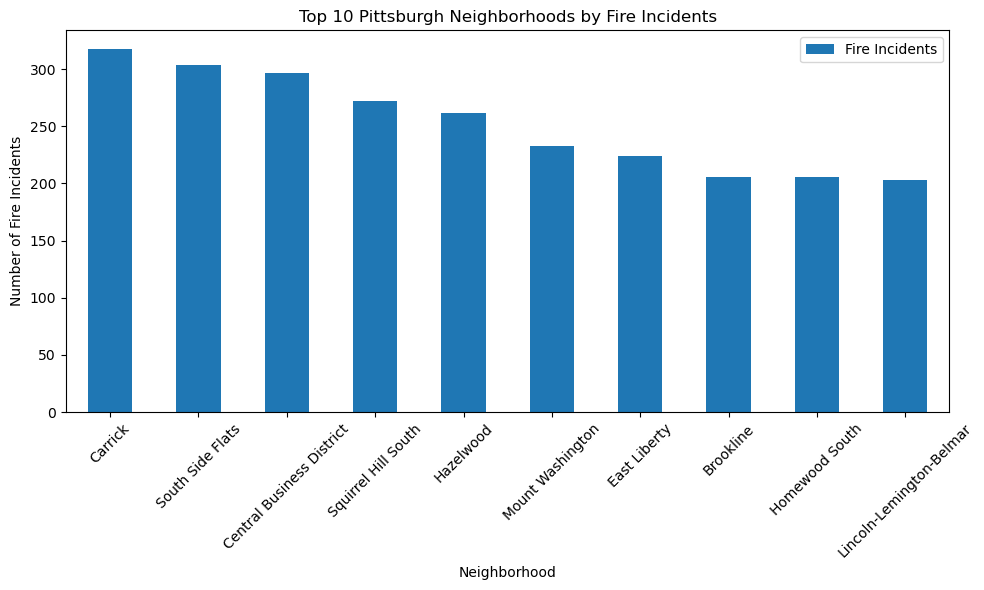

In [15]:
# Top 10 neighborhoods with most fire incidents
fire_counts.head(10).plot(kind='bar', x='Neighborhood', y='Fire Incidents',
                          title='Top 10 Pittsburgh Neighborhoods by Fire Incidents',
                          figsize=(10,6))
plt.ylabel('Number of Fire Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

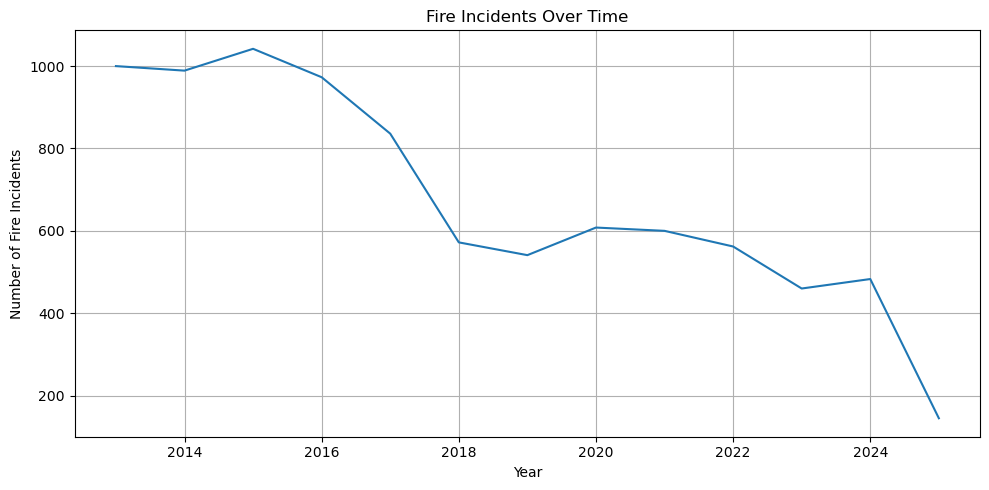

In [16]:
# Convert alarm_time and extract year
fire['alarm_time'] = pd.to_datetime(fire['alarm_time'], errors='coerce')
fire['year'] = fire['alarm_time'].dt.year

# Drop rows with null years
fire_by_year = fire.dropna(subset=['year'])

# Count incidents per year
yearly_counts = fire_by_year['year'].value_counts().sort_index()
yearly_counts.plot(kind='line', title='Fire Incidents Over Time', figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Number of Fire Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()

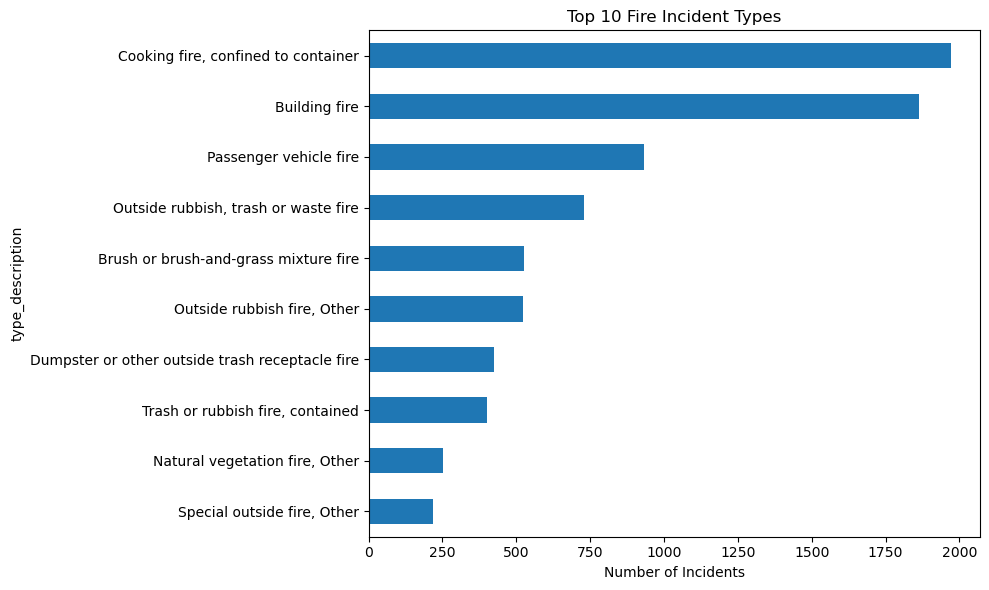

In [17]:
incident_types = fire['type_description'].value_counts().head(10)
incident_types.plot(kind='barh', title='Top 10 Fire Incident Types', figsize=(10, 6))
plt.xlabel('Number of Incidents')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

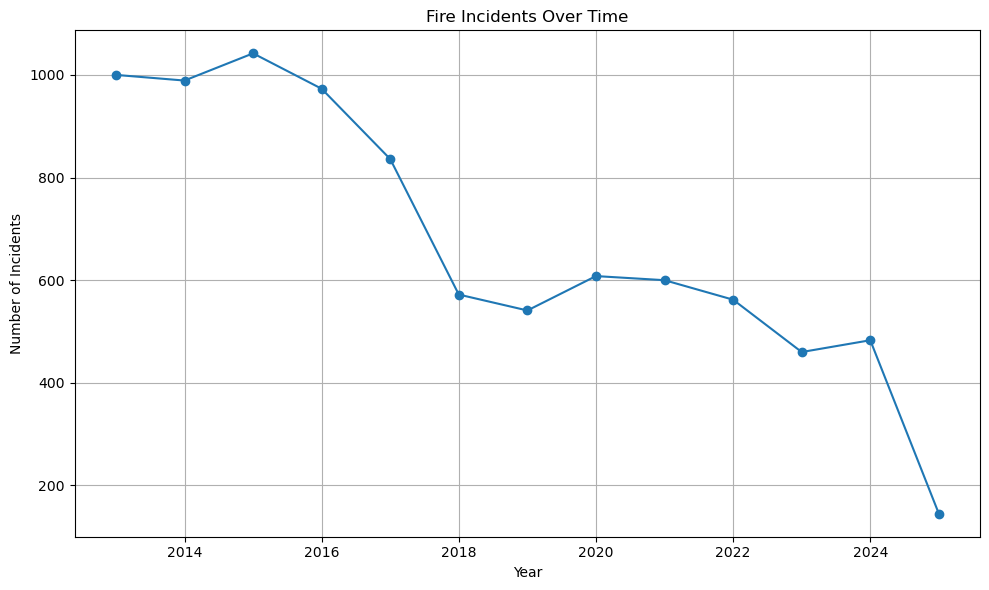

In [18]:
# Remove the comma from year assignment (bug fix)
fire['year'] = fire['alarm_time'].dt.year

# Group by year and count
yearly_counts = fire['year'].value_counts().sort_index()

# Plot
yearly_counts.plot(kind='line', marker='o', title='Fire Incidents Over Time', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()

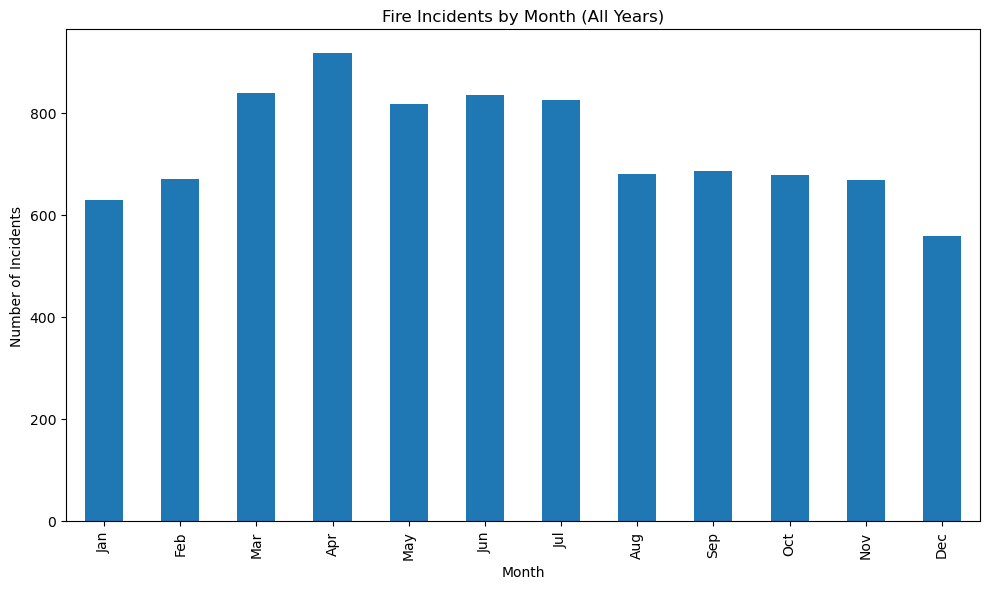

In [19]:
fire['month'] = fire['alarm_time'].dt.month

monthly_counts = fire['month'].value_counts().sort_index()
monthly_counts.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_counts.plot(kind='bar', title='Fire Incidents by Month (All Years)', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

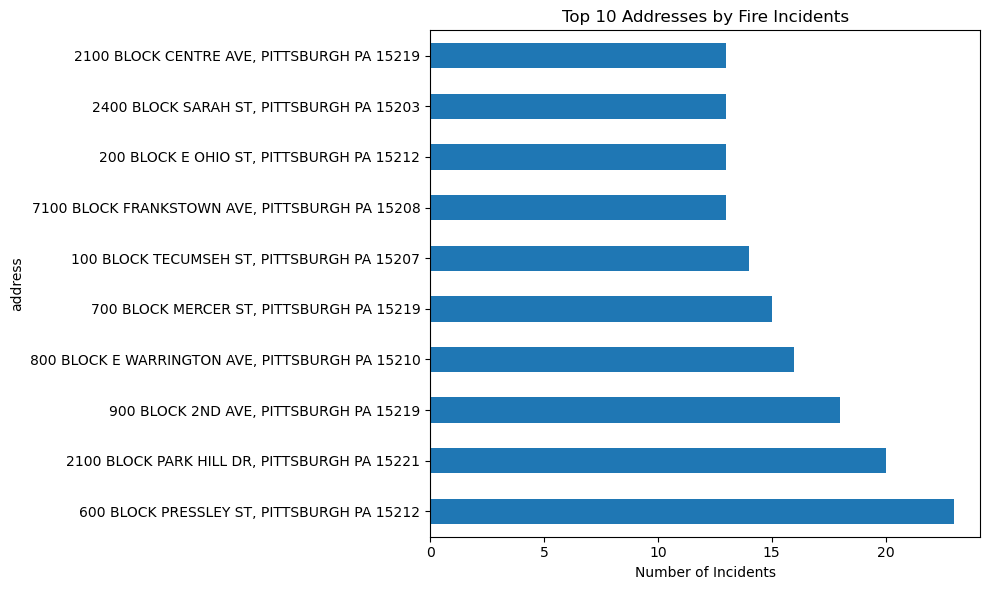

In [20]:
top_streets = fire['address'].value_counts().head(10)
top_streets.plot(kind='barh', title='Top 10 Addresses by Fire Incidents', figsize=(10, 6))
plt.xlabel('Number of Incidents')
plt.tight_layout()
plt.show()

# Conclusion 

#### The analysis of fire incident data within Pittsburgh neighborhoods provides important information regarding the distribution of fire emergencies. Neighborhoods with higher fire incident counts may require increased resource allocation, safety interventions, and risk mitigation strategies. Conversely, areas with fewer recorded incidents may reflect effective fire prevention measures or lower population density. This data supports strategic planning and enhances citywide fire safety management.

# Final Project - Firearm Seizure Metric
# Big Ideas in Computing and Information - University of Pittsburgh

### We can identify the safer neighborhoods based on Firearm Seizures in Pittsburgh. Based on the data gathered from the Western Pennsylvania Regional Data Center, we have access to all neighborhoods within Pittsburgh where Firearms seems to be more prevalent as well how Firearm seizures have increased or decreased over the years. Knowing where firearms have been seized can give an idea of where they are sourced from and what areas to avoid.

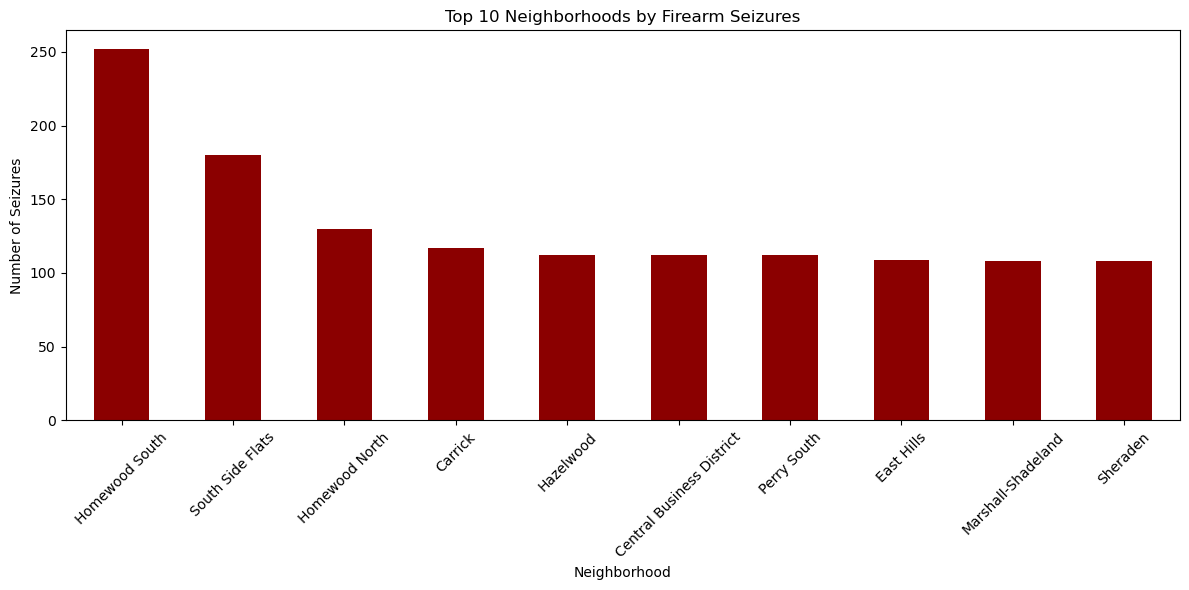

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#load dataset
firearm = pd.read_csv("data/firearms.csv")
firearm.head()

#keep important columns
columns_to_keep = ['neighborhood', 'council_district', 'ward', 'tract', 'police_zone', 'year']
firearm = firearm[columns_to_keep]

#remove missing data
firearm = firearm.dropna(subset=['neighborhood'])

#frequency of firearm seizures
neighborhood_counts = firearm['neighborhood'].value_counts()

#top 10 most seizures (worst for safety), vertical bar chart
plt.figure(figsize = (12, 6))
neighborhood_counts.sort_values(ascending = False).head(10).plot(kind = 'bar', color = 'darkred')
plt.title('Top 10 Neighborhoods by Firearm Seizures')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Seizures')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Here we are able to see the Top 10 Neighborhoods with the most Firearm Seizures. Meaning these areas are not known to be safe.

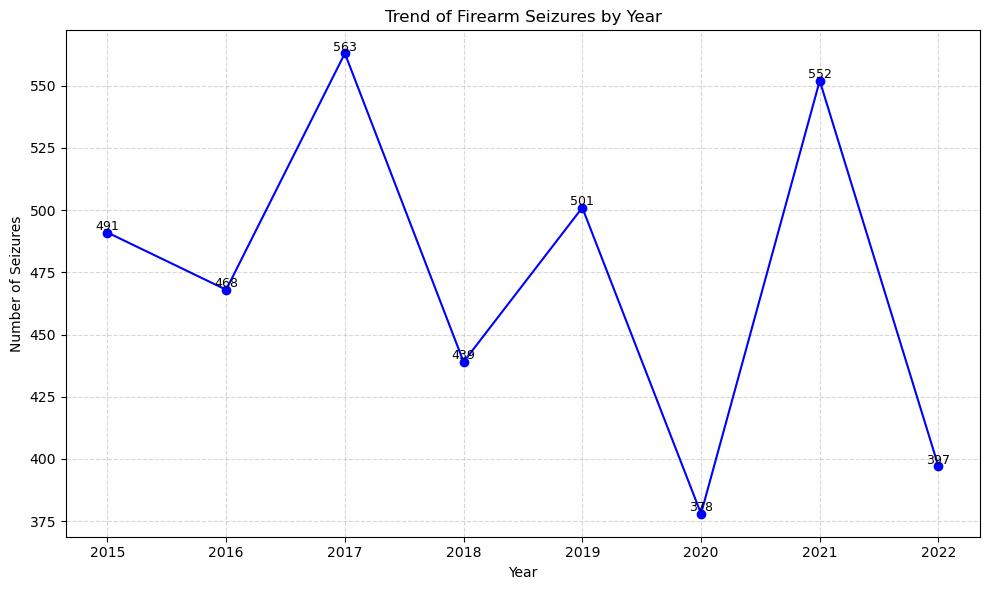

In [2]:
#firearm seizures by year, line plot
if 'year' in firearm.columns:
    year_counts = firearm['year'].value_counts().sort_index()

    plt.figure(figsize = (10, 6))
    plt.plot(year_counts.index, year_counts.values, marker = 'o', linestyle = '-', color = 'blue')
    plt.title('Trend of Firearm Seizures by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Seizures')
    for x, y in zip(year_counts.index, year_counts.values):
        plt.text(x, y + 1, str(y), ha = 'center', fontsize = 9)
    plt.grid(True, linestyle = '--', alpha = 0.5)
    plt.xticks(year_counts.index)
    plt.tight_layout()
    plt.show()

It is interesting to see that the number of firearm seizures vary greatly per year. It appears to flunctuate up every 2 years and back down.

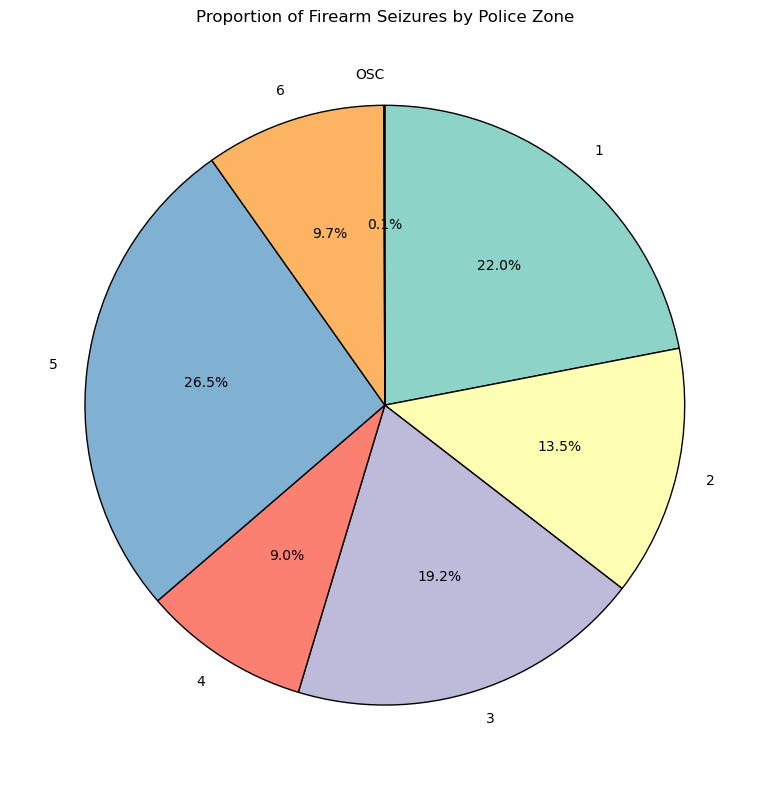

In [4]:
#Firearm seizures based on police zones, pie chart
if 'police_zone' in firearm.columns:
    zone_counts = firearm['police_zone'].value_counts().sort_index()

    plt.figure(figsize=(8, 8))
    zone_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False, 
                         colors=plt.cm.Set3.colors, wedgeprops={'edgecolor': 'black'})
    plt.title('Proportion of Firearm Seizures by Police Zone')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

Here, it is apparent that Police Zone #5 (East Liberty), followed by Police Zone #1 (North Side), has the most firearm seizures.

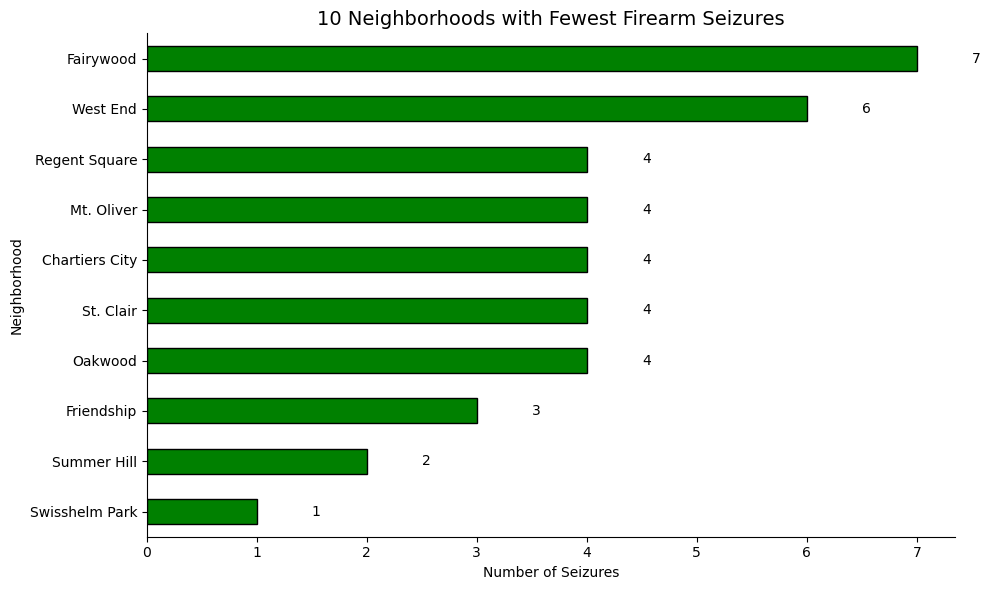

In [5]:
#bottom 10 seizures (best for safety), horizontal bar chart
bottom_10 = neighborhood_counts.sort_values().head(10)

plt.figure(figsize = (10, 6))
ax = bottom_10.plot(kind = 'barh', color = 'green', edgecolor = 'black')
plt.title('10 Neighborhoods with Fewest Firearm Seizures', fontsize = 14)
plt.xlabel('Number of Seizures')
plt.ylabel('Neighborhood')

for i, v in enumerate(bottom_10):
    plt.text(v + 0.5, i, str(v), va = 'center', fontsize = 10)

#remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### Conclusion
As I am new to the area of Pittsburgh, I didn't have much knowledge as to what to expect in terms of frequency of firearm seizures in each neighborhood. I generally had a belief that the neighborhoods near Downtown or past Allegheny River and Monongahela River were known to be on the more dangerous end. I can see based on the data that the far east side of Pittsburgh campus is seen to be generally dangerous, which is shocking due to the fact that I frequent there to visit an animal shelter. It's difficult to assess from the exterior neighborhood where firearm activity is most prevalent, but this dataset allows us to use real evidence to identify those areas more accurately.

